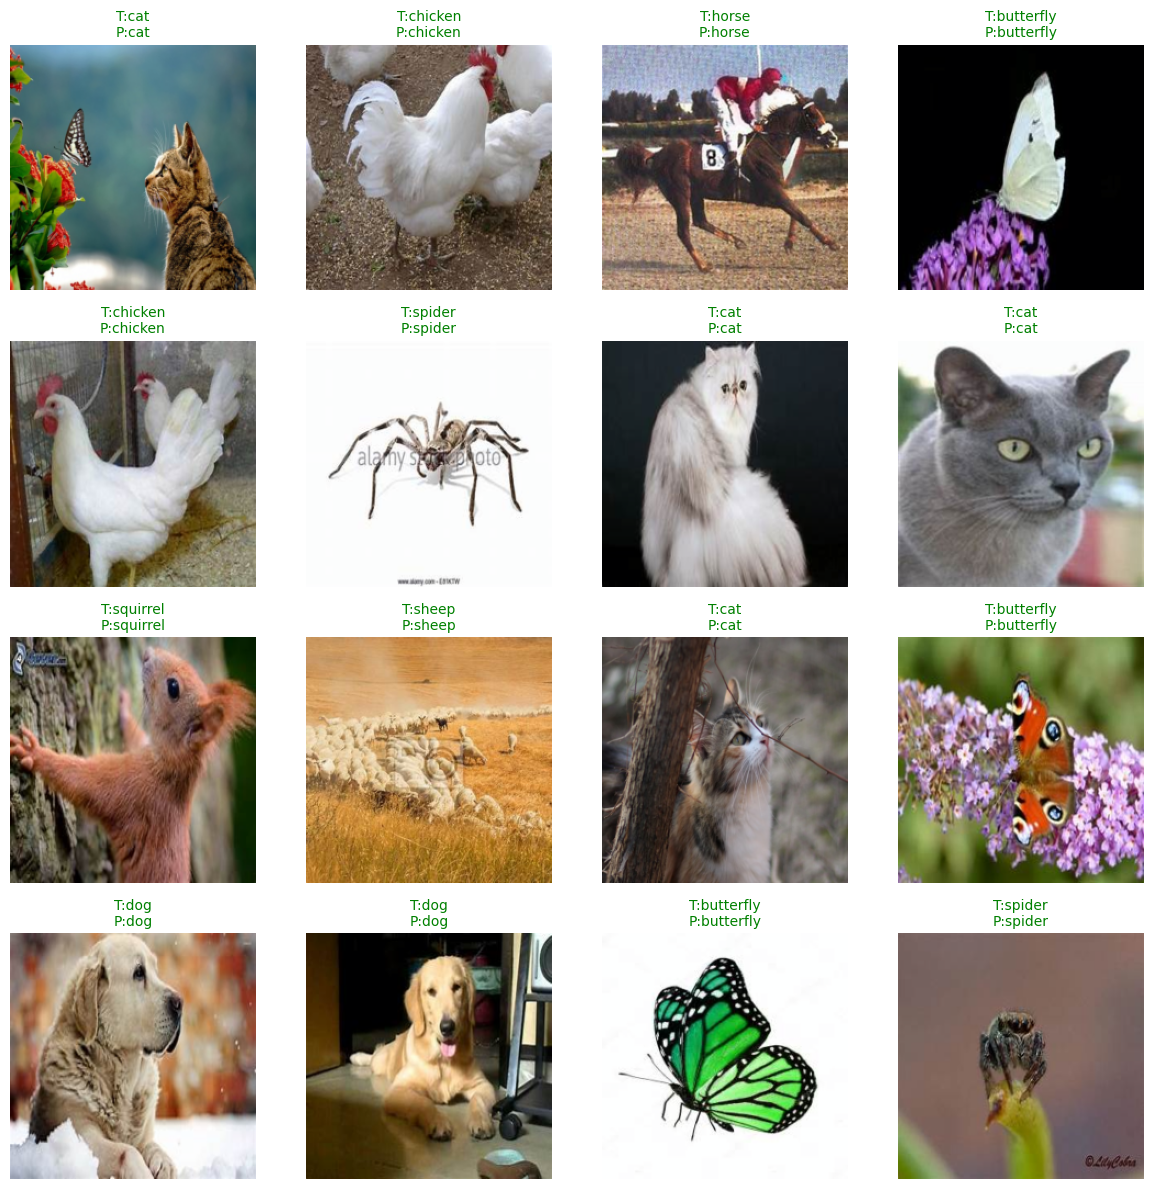

In [3]:
import torch
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from collections import OrderedDict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

state_dict = torch.load("AnimalNet18.pth", map_location=device)
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith("module."):
        new_state_dict[k[7:]] = v
    else:
        new_state_dict[k] = v

model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model.load_state_dict(new_state_dict)
model = model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

test_dataset = ImageFolder(root="./animals10/raw-img", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

def imshow_grid(images, labels, preds, class_names, n=16):
    images = images[:n]
    labels = labels[:n]
    preds = preds[:n]
    fig, axes = plt.subplots(int(np.ceil(n/4)), 4, figsize=(12, 12))
    axes = axes.flatten()
    for i in range(n):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img = std * img + mean
        img = np.clip(img, 0, 1)
        axes[i].imshow(img)
        axes[i].axis("off")
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i]]
        color = "green" if true_label == pred_label else "red"
        axes[i].set_title(f"T:{true_label}\nP:{pred_label}", fontsize=10, color=color)
    for j in range(i+1, len(axes)):
        axes[j].axis("off")
    plt.tight_layout()
    plt.show()

dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, preds = torch.max(outputs, 1)
imshow_grid(images, labels, preds, test_dataset.classes, n=16)
